# **<center>Práctica I: Adversarial Examples</center>**

Los ejemplos adversarios (Adversarial Examples - AE) en redes neuronales han puesto recientemente en duda la robustez de dichas funciones, al ser capaces de cambiar la predicción de una red sin más que perturbar mínimamente los datos de entrada.


El modelo de ataque se describe como la adición de una pertubación:

\begin{align}
    % \delta^* = \mbox{arg}\max_{\delta \in \Delta} \mathcal{L}(y,x+\delta), ~\text{where}~\Delta = \lbrace \delta: ||\delta||_{\infty} \leq \epsilon \rbrace
    x_{adv} &= x + \delta     % \text{ donde } \delta =  \epsilon \cdot sign \left( \frac{\partial \mathcal{L}(y_{target},\hat{y})}{\partial x} \right).
\end{align}
Es decir, buscamos la perturbación $\delta$ de tal forma que la predicción hecha por la red sea distinta a la original:
$$
\hat{y} = f(x, \theta) \neq \hat{y}_{adv} = f(x_{adv}, \theta)
$$  

En este ejercicio se pide construir un ejemplo adversario para una red convolucional. El modelo de ataque a usar se describe a continuación.

### **Non-Targeted Attack:**
$$
 \begin{align}
    % \delta^* = \mbox{arg}\max_{\delta \in \Delta} \mathcal{L}(y,x+\delta), ~\text{where}~\Delta = \lbrace \delta: ||\delta||_{\infty} \leq \epsilon \rbrace
    x_{adv} &= x +  \epsilon \cdot sign \left( \frac{\partial \mathcal{L}(y,\hat{y})}{\partial x} \right).
\end{align}
$$

La perturbación $\delta$ se produce en la dirección de ascenso de la función de pérdidas. Es decir, buscamos que la pérdida (error) asociada al ejemplo $x$ aumente.

### **Targeted Attack:**


\begin{align}
    % \delta^* = \mbox{arg}\max_{\delta \in \Delta} \mathcal{L}(y,x+\delta), ~\text{where}~\Delta = \lbrace \delta: ||\delta||_{\infty} \leq \epsilon \rbrace
    x_{adv} &= x -  \epsilon \cdot sign \left( \frac{\partial \mathcal{L}(y_{target},\hat{y})}{\partial x} \right).
\end{align}
En este caso buscamos la perturbación $\delta$ para una etiqueta diferente de la original. Este ataque es conocido como $\textit{targeted attack}$, y no solo permite engañar a la red sino también forzar su salida en un sentido concreto.

In [ ]:
!pip install ml_collections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Completar


    def forward(self, x):
        # Completar

        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




**Entrenamos una red**

In [ ]:
from ml_collections import ConfigDict

device = 'cuda'

args = ConfigDict()
args.batch_size = 64
args.test_batch_size = 1024
args.epochs = 15
args.log_interval = 10
args.lr = 1e-3


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    ])
train_ds = datasets.CIFAR10('../data', train=True, download=True,
                    transform=transform)
test_ds = datasets.CIFAR10('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.test_batch_size)

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



**Seleccionamos una imagen del conjunto de test**


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


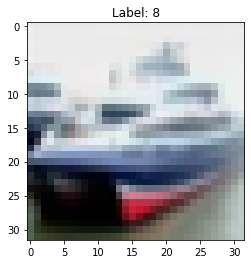

In [ ]:
idx = 1
x = test_ds.data[idx,...]
y = test_ds.targets[idx]
plt.imshow(x)
plt.title('Label: '+str(y))
print(test_ds.classes)

**Non-Targeted Attack**

<IPython.core.display.Latex object>

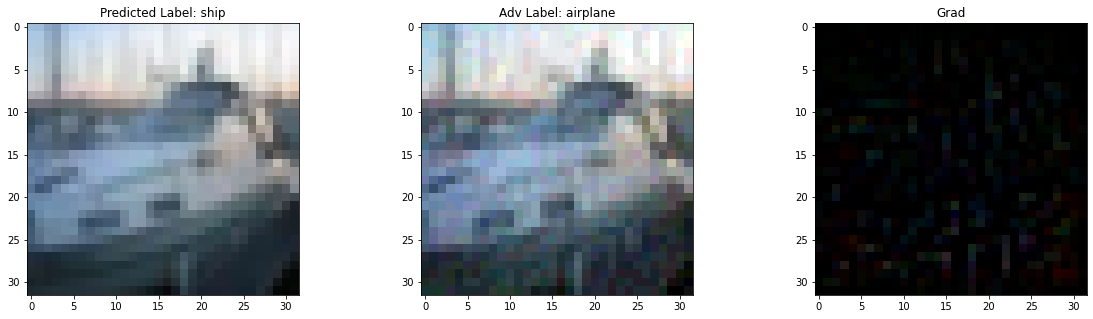

In [ ]:
ep = 8/255

idx = 2
x, y = next(iter(test_loader))
x = x[idx:idx+1,...]
y = y[idx:idx+1,...]
x = nn.Parameter(x)

x, y = x.to(device), y.to(device)

y_hat = model(x)

loss = F.nll_loss(y_hat, y, reduction='mean')
grad =  # Completar
x_adv =  # Completar
y_hat_adv = model(x_adv)


x = x.permute(0,2,3,1)[0].detach().cpu().numpy()
x_adv = x_adv.permute(0,2,3,1)[0].detach().cpu().numpy()
grad = grad.permute(0,2,3,1)[0].detach().cpu().numpy()

diff = abs(x - x_adv)
from IPython.display import display, Latex

display(Latex('\delta = ||x_{org} - x_{adv} ||_\infty '+' = {:.04f}'.format(diff.max())))

fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].imshow(x)
axs[0].set_title('Predicted Label: '+ str(test_ds.classes[y_hat[0].argmax().cpu().numpy()]))
axs[1].imshow(x_adv)
axs[1].set_title('Adv Label: '+ str(test_ds.classes[y_hat_adv[0].argmax().cpu().numpy()]))
axs[2].imshow(grad)
axs[2].set_title('Grad')
plt.show()



**Targeted Attack**

<IPython.core.display.Latex object>

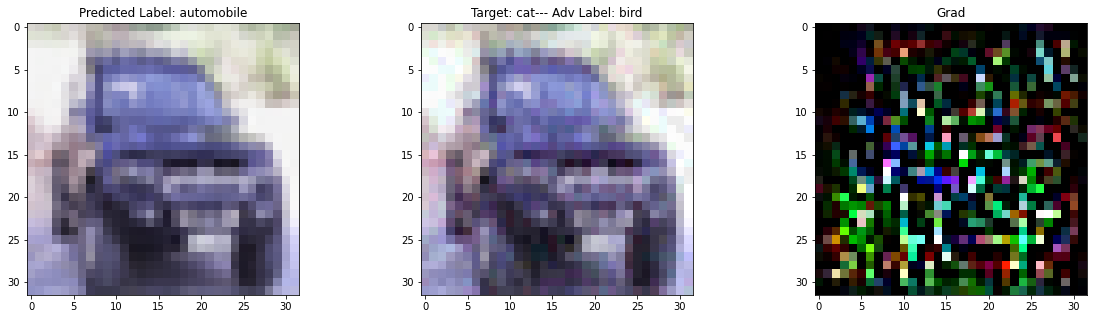

In [ ]:
ep = 8/255


idx = 9
x, y = next(iter(test_loader))
x = x[idx:idx+1,...]
y = y[idx:idx+1,...]
x = nn.Parameter(x)

y_target =  # Completar

x, y = x.to(device), y.to(device)

y_hat = model(x)

loss = F.nll_loss(y_hat, y_target, reduction='mean')
grad = # Completar
x_adv = # Completar
y_hat_adv = model(x_adv)


x = x.permute(0,2,3,1)[0].detach().cpu().numpy()
x_adv = x_adv.permute(0,2,3,1)[0].detach().cpu().numpy()
grad = grad.permute(0,2,3,1)[0].detach().cpu().numpy()

diff = abs(x - x_adv)
from IPython.display import display, Latex

display(Latex('\delta = ||x_{org} - x_{adv} ||_\infty '+' = {:.04f}'.format(diff.max())))

fig, axs = plt.subplots(1,3, figsize=(20,5))

axs[0].imshow(x)
axs[0].set_title('Predicted Label: '+ str(test_ds.classes[y_hat[0].argmax().cpu().numpy()]))
axs[1].imshow(x_adv)
axs[1].set_title('Target: '+str(test_ds.classes[y_target])+'--- Adv Label: '+ str(test_ds.classes[y_hat_adv[0].argmax().cpu().numpy()]))
axs[2].imshow(grad)
axs[2].set_title('Grad')
plt.show()

In [ ]:
def adv_test(model, device, test_loader, ep=8/255):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = nn.Parameter(data)
        output = model(data)

        loss = F.nll_loss(output, target, reduction='mean')

        grad = torch.autograd.grad(loss, data)[0]
        x_adv = data + ep*torch.sign(grad)

        with torch.no_grad():

          y_hat_adv = model(x_adv)

          pred = y_hat_adv.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

adv_test(model, device, test_loader, ep=0/255)
adv_test(model, device, test_loader, ep=8/255)

In [ ]:
def adv_train(args, model, device, train_loader, optimizer, epoch, ep=8/255):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        data = nn.Parameter(data)
        # output = model(data)
        loss = F.nll_loss(output, target, reduction='mean')
        grad = torch.autograd.grad(loss, data)[0]

        x_adv = data + ep*torch.sign(grad)
        x_adv = torch.clip(x_adv, 0,1)

        data = x_adv.detach()

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

model_adv = Net().to(device)

optimizer_adv = optim.Adam(model_adv.parameters(), lr=args.lr)

for epoch in range(1, args.epochs + 1):
    adv_train(args, model_adv, device, train_loader, optimizer_adv, epoch)
    test(model_adv, device, test_loader)

adv_test(model, device, test_loader, ep=0/255)
adv_test(model, device, test_loader, ep=8/255)
adv_test(model_adv, device, test_loader, ep=0/255)
adv_test(model_adv, device, test_loader, ep=8/255)